## SQIG Trading Competition - The Code

In this Jupyter Notebook document, you will find the code for my SQIG Trading Competition submission. The code snippets and thought processes are split up into steps for clarity.

### Step 1: Prepare, lag and split the dataset

This section begins by importing essential libraries for data manipulation, visualization, modeling, and evaluation. The dataset is then loaded and cleaned by removing any missing values. Key features (`VIX`, `T-Bill_13W_Yield`, and `10Y_Treasury_Yield`) are selected along with the target variable (`Credit_Spread`). To preserve the temporal structure, input features are lagged by one time step, allowing the model to predict the credit spread at time *t* using information from time *t–1*. Finally, the lagged dataset is split into training and testing sets using an 80/20 ratio.

In [64]:
# NOTE: If any required modules are not currently installed, run "!pip install module_name" in a cell
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
import shap

from sklearn.model_selection import TimeSeriesSplit, train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error  # For loss function

df = pd.read_csv("SQIG_data.csv", parse_dates=True, index_col=0)

# Drop missing values first to clean data
df.dropna(inplace=True)

# Then select features and target
features = ["VIX", "T-Bill_13W_Yield", "10Y_Treasury_Yield"]
X = df[features]
y = df["Credit_Spread"]

# Lag inputs and keep output (credit spread in place) to ensure model learns to predict the credit spread at time t using input features from time t-1
X_lagged = X.shift(1).dropna()
y_lagged = y.loc[X_lagged.index]

# Then split train-test (80%-20% train-test split) using lagged features
split_index = int(len(X_lagged) * 0.8)
X_train, X_test = X_lagged.iloc[:split_index], X_lagged.iloc[split_index:]
y_train, y_test = y_lagged.iloc[:split_index], y_lagged.iloc[split_index:]

### Step 2: Train and Evaluate a Random Forest Regressor as a Baseline Model

In this step, I train a Random Forest Regressor to establish a baseline for predicting credit spreads. After fitting the model on the training set, I evaluate its performance on the test set using RMSE and MAE. I also compute the training RMSE to assess potential overfitting.

To further evaluate generalization, I perform 5-fold expanding window time series cross-validation using `TimeSeriesSplit`, calculating the RMSE for each fold.

Finally, I analyse feature importances from the trained model to identify which variables most influence credit spread predictions. I also use SHAP (SHapley Additive exPlanations) values to interpret the model’s predictions and visualise the impact of each feature.

Random Forest Test RMSE: 0.38196212600095214
Random Forest MAE : 0.3030319818839385
Random Forest Training RMSE: 0.13526179298690608
Random Forest CV RMSE (mean ± std) : 0.3725 ± 0.0107


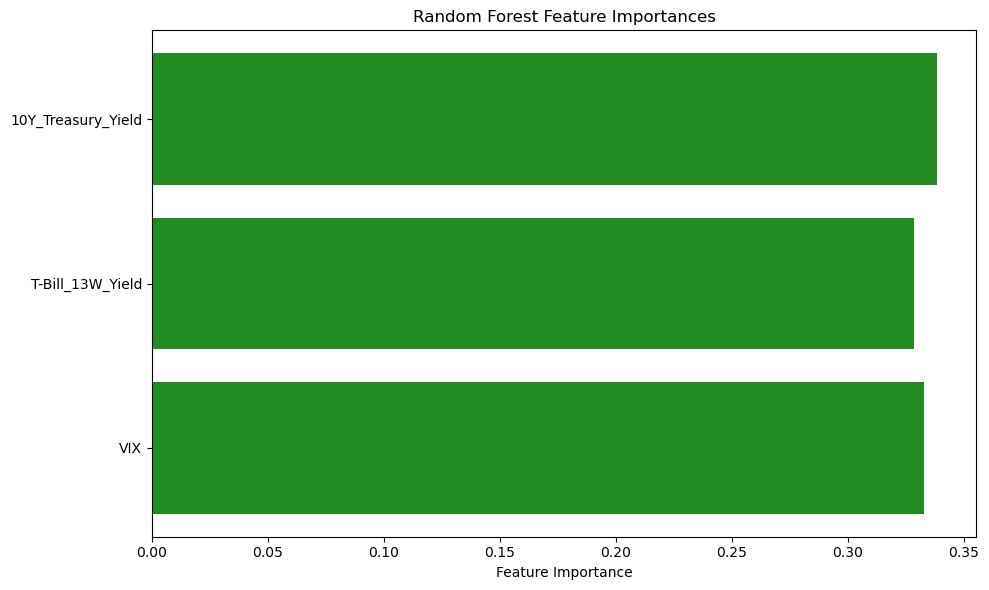

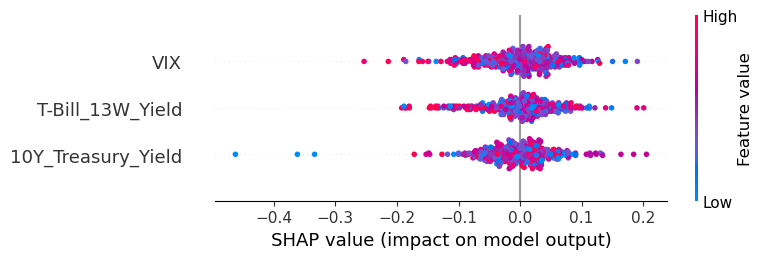

In [65]:
# Instantiate the model
rf_model = RandomForestRegressor(
    n_estimators=100,    
    max_depth=None,     
    random_state=42
)

# Fit to training data
rf_model.fit(X_train, y_train)

# Predict on test data
y_rf_pred = rf_model.predict(X_test)

# Evaluate
rf_rmse = np.sqrt(mean_squared_error(y_test, y_rf_pred))
rf_mae = mean_absolute_error(y_test, y_rf_pred)

print(f"Random Forest Test RMSE: {rf_rmse}")
print(f"Random Forest MAE : {rf_mae}")

# Also check for training RMSE for overfit checking
y_train_pred = rf_model.predict(X_train)
train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
print(f"Random Forest Training RMSE: {train_rmse}")

# ----------Quick check for overfitting/generalisation---------------------------
# Use 5-fold expanding time series CV (a different form of k-fold testing) - here, TimeSeriesSplit(n_splits=5) expands the training window in each iterartion and keeps the validation window the same size in each fold.
tscv = TimeSeriesSplit(n_splits=5)

rf_cv_rmse_scores = []

for train_idx, val_idx in tscv.split(X_lagged):
    X_train_cv, X_val_cv = X_lagged.iloc[train_idx], X_lagged.iloc[val_idx]
    y_train_cv, y_val_cv = y_lagged.iloc[train_idx], y_lagged.iloc[val_idx]

    rf_model.fit(X_train_cv, y_train_cv)
    y_val_pred = rf_model.predict(X_val_cv)  # Predict on validation data for given fold to then compare with correct predictions

    rmse = np.sqrt(mean_squared_error(y_val_cv, y_val_pred))
    rf_cv_rmse_scores.append(rmse)

rf_cv_rmse_scores = np.array(rf_cv_rmse_scores)
print(f"Random Forest CV RMSE (mean ± std) : {rf_cv_rmse_scores.mean():.4f} ± {rf_cv_rmse_scores.std():.4f}")

# -----------Feature Importance - What does RF think matters most?---------------
importances = rf_model.feature_importances_
feature_names = X.columns

plt.figure(figsize=(10, 6))
plt.barh(feature_names, importances, color="forestgreen")
plt.xlabel("Feature Importance")
plt.title("Random Forest Feature Importances")
plt.tight_layout()
plt.show()

# ----------------------SHAP plots--------------------------------------------

explainer_rf = shap.TreeExplainer(rf_model)
shap_values_rf = explainer_rf.shap_values(X_test)

shap.summary_plot(shap_values_rf, X_test, plot_type="dot", show=True)

### Interpretation of Results

- The similarity between the test RMSE and cross-validation RMSE indicates that the Random Forest model performs consistently on both the test set and unseen data during cross-validation.
- This consistency suggests low overfitting and good generalisation. Additionally, the low standard deviation of 0.0107 across folds points to stable and reliable predictions.
- A moderate gap of about 0.2 between training and test RMSE suggests only slight overfitting.
- The fairly uniform feature importances imply that all features contribute meaningfully to predicting credit spreads. This aligns well with economic intuition, as VIX and Treasury yields capture complementary risk factors - VIX reflects market risk sentiment, while Treasury yields represent macroeconomic expectations - both naturally influencing credit spread dynamics.

### Step 3: Enhance Prediction with XGBoost Using Gradient Boosting

In this step, I utilise XGBoost - a powerful gradient boosting algorithm - to predict credit spreads. After training the model on the training data, I evaluate its out-of-sample performance using RMSE and MAE, comparing these metrics against the Random Forest baseline.

To assess the model’s generalisation capability and robustness, I perform time series cross-validation, calculating RMSE scores across folds. Although XGBoost may sometimes have slightly higher errors, it often offers improved predictive stability.

Finally, I examine feature importances both through built-in XGBoost metrics and SHAP values to gain insights into which variables drive the model’s predictions.

XGBoost RMSE: 0.3635
XGBoost MAE : 0.2906
XGBoost CV RMSE (mean ± std): 0.3619 ± 0.0154


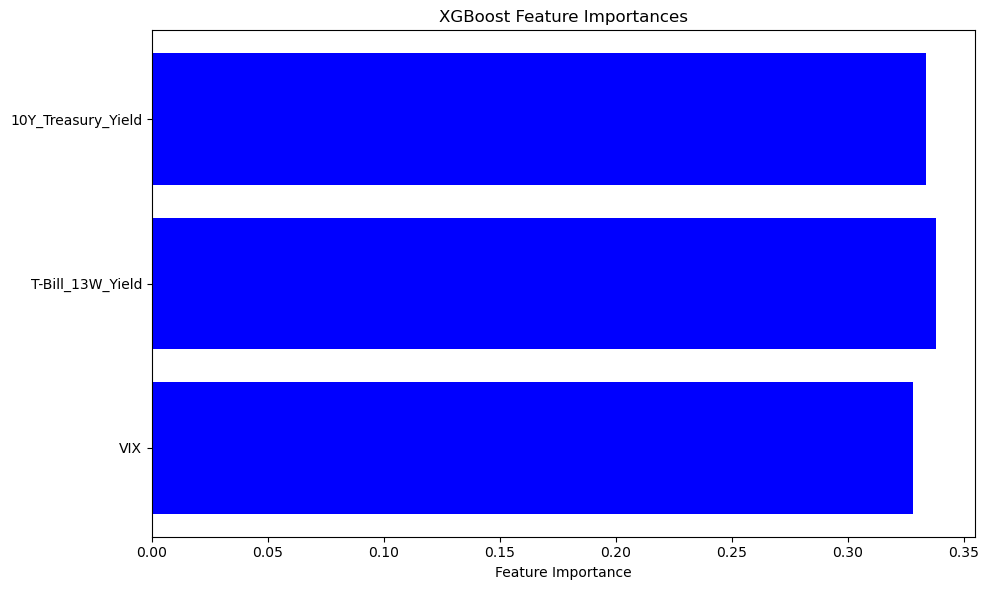

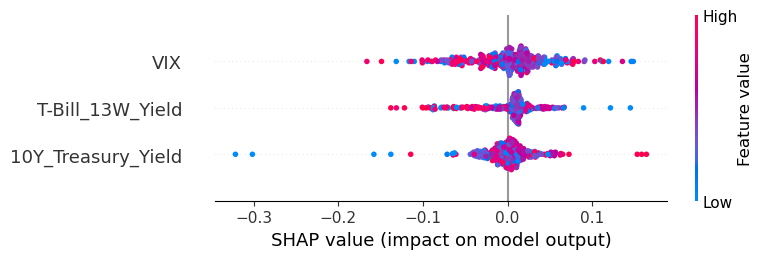

In [66]:
# Instantiate the model
xgb_model = xgb.XGBRegressor(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=3,
    random_state=42
)

# Train model
xgb_model.fit(X_train, y_train)

# Make predictions
y_xgb_pred = xgb_model.predict(X_test)

# Evaluate
xgb_rmse = np.sqrt(mean_squared_error(y_test, y_xgb_pred))
xgb_mae = mean_absolute_error(y_test, y_xgb_pred)

print(f"XGBoost RMSE: {xgb_rmse:.4f}")
print(f"XGBoost MAE : {xgb_mae:.4f}")

# ----------Quick check for overfitting/generalisation---------------------------
xgb_cv_rmse_scores = []

for train_idx, val_idx in tscv.split(X_lagged):
    X_train_cv, X_val_cv = X_lagged.iloc[train_idx], X_lagged.iloc[val_idx]
    y_train_cv, y_val_cv = y_lagged.iloc[train_idx], y_lagged.iloc[val_idx]
    
    xgb_model.fit(X_train_cv, y_train_cv)
    y_val_pred = xgb_model.predict(X_val_cv)
    
    rmse = np.sqrt(mean_squared_error(y_val_cv, y_val_pred))
    xgb_cv_rmse_scores.append(rmse)

xgb_cv_rmse_scores = np.array(xgb_cv_rmse_scores)
print(f"XGBoost CV RMSE (mean ± std): {xgb_cv_rmse_scores.mean():.4f} ± {xgb_cv_rmse_scores.std():.4f}")

importances = xgb_model.feature_importances_
feature_names = X.columns

# Display feature importance visually
plt.figure(figsize=(10, 6))
plt.barh(feature_names, importances, color="blue")
plt.xlabel("Feature Importance")
plt.title("XGBoost Feature Importances")
plt.tight_layout()
plt.show()

# -----------------------SHAP plots----------------------------------------
explainer_xgb = shap.TreeExplainer(xgb_model)
shap_values_xgb = explainer_xgb.shap_values(X_test)

shap.summary_plot(shap_values_xgb, X_test, plot_type="dot", show=True)

### Interpretation of Results

Comparing the performance of the Random Forest and XGBoost models across key metrics—including test RMSE, MAE, cross-validation RMSE, and feature importance—XGBoost demonstrates more consistent generalization and slightly better performance on the test split.

Both models identify the 10Y Treasury Yield and short-term T-Bill yields as important predictors of credit spreads. However, XGBoost assigns slightly less importance to the VIX, suggesting it views market volatility as a less dominant factor than Random Forest does.

The SHAP summary plots further highlight differences in model behavior. XGBoost shows a tighter distribution of SHAP values, indicating more stable and consistent feature impacts across the test set. In contrast, Random Forest exhibits a wider spread, implying that it may capture more complex interactions or outlier behavior, but at the cost of increased variability.

Taking all of this into account, the **XGBoost model** appears to be the better choice moving forward. It offers slightly improved performance, better generalisation, and more predictable feature behavior - making it a more robust and reliable model for this task.

### Step 4: Evaluation of XGBoost

After comparing both Random Forest and XGBoost models, I finalise XGBoost as the preferred choice due to its consistent generalisation, strong performance, and built-in regularisation. I also evaluate **directional accuracy** to assess how well the model captures the trend in credit spreads, which is a critical insight for trading desks focused more on movement direction than exact values.

#### Why XGBoost?

After comparing Random Forest and XGBoost using multiple performance metrics and validation strategies, XGBoost is chosen as the final model due to the following reasons:

- **Competitive performance:** XGBoost slightly outperformed on the test set and XGBoost's test RMSE of 0.3635 and MAE of 0.2906 remain strong and within close range.

- **Greater Stability:** The lower spread of features seen in the XGBoost SHAP plot compared to the SHAP plot for the Random Forest model suggest that XGBoost behaves with greater stability, which is more important in this context.

- **Regularisation:** XGBoost uses L1/L2 regularisation, helping reduce overfitting tendencies.

#### Use Case: Custom Prediction with XGBoost

Let’s simulate a prediction using user-defined inputs for:

- VIX

- 13-Week T-Bill Yield

- 10-Year Treasury Yield

In [67]:
user_input  = pd.DataFrame([{
    "VIX": 16.0,
    "T-Bill_13W_Yield": 0.8,
    "10Y_Treasury_Yield": 2.4
}])

xgb_predicted_credit_spread = xgb_model.predict(user_input)[0]
print(f"Predicted Credit Spread: {xgb_predicted_credit_spread:.4f}")

Predicted Credit Spread: 1.5106


#### Interpretation of Predicted Credit Spread

Hopefully, the above use case shows how a user (or financial analyst) could input current market conditions and **instantly receive a model-driven credit spread estimate**, which they can then use for real-time risk assessment or pricing decisions.

#### Directional Accuracy Evaluation

In this step, I evaluate the **directional accuracy** of the model—that is, how well it predicts the **direction of change** in the credit spread (upward or downward) rather than the exact value.

Using expanding window time series cross-validation (`TimeSeriesSplit`), I compute directional accuracy across multiple folds. For each fold, I train an XGBoost model, predict the test set, and compare the **sign of changes** in predicted values to the actual changes in credit spreads.

The final output is the **mean directional accuracy** along with its standard deviation across folds, providing a robust, multi-period assessment of how well the model captures directional movement.

> *Note: TimeSeriesSplit is used to avoid overinterpreting single-period performance and to reflect realistic, sequential model evaluation.*


In [68]:
directional_accuracies = []

for train_index, test_index in tscv.split(X_lagged):
    X_train_cv, X_test_cv = X_lagged.iloc[train_index], X_lagged.iloc[test_index]
    y_train_cv, y_test_cv = y_lagged.iloc[train_index], y_lagged.iloc[test_index]

    # Train model
    xgb_model_cv = xgb.XGBRegressor(
        n_estimators=100,
        learning_rate=0.1,
        max_depth=3,
        random_state=42
    )
    xgb_model_cv.fit(X_train_cv, y_train_cv)
    
    # Predict on current fold's test set
    y_pred_cv = pd.Series(xgb_model_cv.predict(X_test_cv), index=X_test_cv.index)

    # Compute direction changes
    y_diff = y_test_cv.diff().dropna()
    y_pred_diff = y_pred_cv.diff().dropna()

    # Align
    y_diff = y_diff.loc[y_pred_diff.index]

    # Compute directional accuracy for this fold
    da = (np.sign(y_diff) == np.sign(y_pred_diff)).mean()
    directional_accuracies.append(da)

# Final cross-validated directional accuracy
mean_da = np.mean(directional_accuracies)
std_da = np.std(directional_accuracies)

print(f"Cross-Validated Directional Accuracy: {mean_da:.2%} ± {std_da:.2%}")

# NOTE: WE USE TIMESERIESSPLIT FOR OUR DIRECTIONAL ACCURACY CALCULATION AS IT IS MULTI-PERIOD (RATHER THAN FROM ONE PERIOD) AND HENCE PREVENTS OVER/UNDER-INTERPRETING ONE-OFF RESULTS

Cross-Validated Directional Accuracy: 48.98% ± 2.47%


#### Interpretation of Directional Accuracy Results:

The cross-validated directional accuracy of the XGBoost model is approximately **48.98% ± 2.47%**, indicating that the model predicts the direction of change in credit spreads only marginally better than random chance.

While this result suggests **limited reliability in anticipating short-term spread movements**, it still provides value in certain contexts. For **credit traders and portfolio strategists**, even a slight edge in directional signals can be useful when combined with other market indicators or qualitative insights. It highlights the challenge of predicting direction in noisy financial time series, and underscores the importance of integrating quantitative models into a broader decision-making framework.

### Step 5: Interpretability and Strategic Takeaways

In this step, I use the XGBoost model's predicted credit spreads to build a weekly trading strategy that dynamically adjusts ETF allocations based on macro risk regimes. By combining predicted spread levels with VIX, I classify each week as either "High Risk" or "Low Risk" and allocate accordingly - favouring defensive ETFs in high-risk environments and growth-oriented ETFs when risk is low. A directional spread signal (tightening/widening) adds tactical nuance. This section also includes a review of strategic takeaways and suggestions for improving both the model and the strategy going forward.

As a reminder, I have already analysed feature importance for both Random Forest and XGBoost.

### Interpretation of Feature Weights

- The model assigns **high and nearly equal importance** to all three features: the 10Y Treasury yield, the 13-week T-Bill rate, and the VIX.
  
- This suggests that **each variable contributes meaningfully and independently** to predicting credit spreads, with no single driver dominating the model’s decision-making process.

- From an economic perspective, this is intuitive. The **yield curve** (both short- and long-term rates) captures interest rate expectations and macroeconomic conditions, while the **VIX reflects market sentiment and risk appetite**. Together, they represent complementary dimensions of credit risk.

This result supports the idea that credit spreads are influenced by a **balanced interplay of macro-financial factors**, and reinforces the need for multi-factor models in credit risk forecasting.

### Regime-Wise Error Analysis

I now analyse model error across different market regimes to spot where it performs better or worse as this will help inform a regime-switching strategy.

In [69]:
# Define regimes using VIX and credit spread
regime = np.where((df["VIX"] < 20) & (df["Credit_Spread"] < 1.5), "Low Risk", "High Risk")
df["Regime"] = regime

# Create an independent copy
X_test = X_test.copy()

# Add model predictions and errors to test set portion
X_test["Predicted_CS"] = y_xgb_pred
X_test["Actual_CS"] = y_test
X_test["Error"] = np.abs(X_test["Predicted_CS"] - X_test["Actual_CS"])

# Add regime information
X_test["Regime"] = df.loc[X_test.index, "Regime"]

# MAE by regime
error_by_regime = X_test.groupby("Regime")["Error"].mean()

print(error_by_regime)

Regime
High Risk    0.286251
Low Risk     0.301974
Name: Error, dtype: float64


### Interpretation of Error Analysis Figures

The errors by regime above show the following:

- The XGBoost model performs slightly better in the High Risk regime, with a lower average prediction error.

- The difference in MAE between the regimes is very small (~0.015), suggesting the model is robust across macro regimes.

- This is a strong result, particularly since model performance often suffers more under high-risk or volatile conditions.

### Credit Trading Strategy using our XGBoost Model

Now, I create a macro volatility-aware trading strategy that:

- Uses XGBoost model predictions of credit spreads.

- Dynamically switches ETF allocations based on regime (Low Risk vs High Risk).

- Responds to model-predicted spread changes rather than just raw market data.

- Compares strategy vs. a benchmark performance.

In [70]:
# Recalculate Regime using model-predicted Credit Spread
predicted_cs_full = xgb_model.predict(X_lagged)
df.loc[X_lagged.index, "Predicted_CS"] = predicted_cs_full

df["Regime_ModelBased"] = np.where(
    (df["VIX"] < 20) & (df["Predicted_CS"] < 1.5),
    "Low Risk",
    "High Risk"
)

# Which ETFs to hold in each regime
etf_allocation = {
    "Low Risk": ["ARKQ", "QCLN", "BOTZ"],
    "High Risk": ["ICLN", "ROBO"]
}

# -----------------Simulate Allocations based on predicted regimes-----------------------
# Weekly rebalancing
df.index = pd.to_datetime(df.index, dayfirst=True)
df_weekly = df.resample("W").last()  # Weekly frequency

# Determine ETFs held weekly
df_weekly["ETFs_Held"] = df_weekly["Regime_ModelBased"].map(etf_allocation)


# --------------------Trading Signalling----------------------------------
df_weekly["Spread_Change"] = df_weekly["Predicted_CS"].diff()

df_weekly["Signal"] = np.where(
    df_weekly["Spread_Change"] > 0, "Widening",
    np.where(df_weekly["Spread_Change"] < 0, "Tightening", "Stable")
)

print(df_weekly[["Predicted_CS", "Regime_ModelBased", "ETFs_Held", "Signal"]].head(20))

print(df_weekly[["Predicted_CS", "Regime_ModelBased", "ETFs_Held", "Signal"]].tail(10))

            Predicted_CS Regime_ModelBased           ETFs_Held      Signal
2018-01-07      1.521268         High Risk        [ICLN, ROBO]      Stable
2018-01-14      1.612895         High Risk        [ICLN, ROBO]    Widening
2018-01-21      1.533506         High Risk        [ICLN, ROBO]  Tightening
2018-01-28      1.286150         High Risk        [ICLN, ROBO]  Tightening
2018-02-04      1.470045          Low Risk  [ARKQ, QCLN, BOTZ]    Widening
2018-02-11      1.634182         High Risk        [ICLN, ROBO]    Widening
2018-02-18      1.524904         High Risk        [ICLN, ROBO]  Tightening
2018-02-25      1.514507         High Risk        [ICLN, ROBO]  Tightening
2018-03-04      1.492300          Low Risk  [ARKQ, QCLN, BOTZ]  Tightening
2018-03-11      1.533506         High Risk        [ICLN, ROBO]    Widening
2018-03-18      1.291091          Low Risk  [ARKQ, QCLN, BOTZ]  Tightening
2018-03-25      1.518341         High Risk        [ICLN, ROBO]    Widening
2018-04-01      1.449745 

### Interpretation of Trading Strategy

The model-generated weekly signals create a dynamic, macro-aware trading strategy that uses predicted credit spreads and VIX to determine market regimes, and adjust ETF exposure accordingly.

Strategy Logic Recap:
- Model predicts credit spread (Predicted_CS) each week.

- A regime is classified as:

    - Low Risk → VIX < 20 and Predicted_CS < 1.5

    - High Risk → All other cases.

- ETF exposure shifts weekly based on regime.

- Spread direction signal (Widening, Tightening, Stable) adds tactical overlay.


**Code Output Breakdown (Example head of table):**

| Week       | Predicted\_CS | Regime       | ETFs Held            | Signal     | Interpretation                                                        |
| ---------- | ------------- | ------------ | -------------------- | ---------- | --------------------------------------------------------------------- |
| 2024-11-03 | 1.71          | High Risk    | ICLN, ROBO           | Widening   | Risk regime → stay defensive, spreads worsening.                      |
| 2024-11-10 | 2.28          | High Risk    | ICLN, ROBO           | Widening   | Continue defensive allocation.                                        |
| 2024-11-17 | 1.57          | High Risk    | ICLN, ROBO           | Tightening | Early signal of potential risk easing, but still in High Risk regime. |
| 2024-11-24 | 1.13          | High Risk    | ICLN, ROBO           | Tightening | Spread tightening, but regime hasn't shifted yet.                     |
| 2024-12-01 | 1.31          | High Risk    | ICLN, ROBO           | Widening   | Regime remains High Risk → continue defensive.                        |
| 2024-12-08 | 2.07          | High Risk    | ICLN, ROBO           | Widening   | Deteriorating credit → risk-off still preferred.                      |
| 2024-12-15 | 1.79          | High Risk    | ICLN, ROBO           | Tightening | Slight relief, but regime hasn’t flipped.                             |
| 2024-12-22 | 1.33          | **Low Risk** | **ARKQ, QCLN, BOTZ** | Tightening | First flip to Low Risk → rotate into and hold more growth-oriented ETFs.            |
| 2024-12-29 | 1.29          | High Risk    | ICLN, ROBO           | Tightening | Regime back to High Risk (VIX may have risen).                        |
| 2025-01-05 | 1.42          | High Risk    | ICLN, ROBO           | Widening   | Worsening again → hold defensive ETFs onward.                         |

**Summary of Trading Strategy**

The trading logic above implements:

Regime Switching
- Allocates to either growth ETFs (e.g., ARKQ, QCLN, BOTZ) or defensive ETFs (e.g., ICLN, ROBO) weekly based on model-based credit stress signals.

Directional Overlay
- Helps confirm or challenge allocation decisions.

- Example: Even if you're in a High Risk regime, consistent tightening signals may indicate easing risk, which could be a potential precursor to a regime flip.

**Use Case for a Credit Trading Desk**

A credit desk can use this as a **quantitative overlay** or a **signal-generation tool** in:

Risk-On / Risk-Off Positioning
- Model-guided signals help the desk rotate between IG, HY, credit derivatives, or macro ETFs accordingly.

Forward-Looking Signal
- Trading desks typically use backward-looking indicators. This approach uses forward-looking credit spread movement (tightening/widening), offering lead-time vs. lagged indicators.

Cross-Asset Allocation Overlay
- The ETF rotation can be adapted to sector bets (e.g., long growth, short cyclical), or macro hedges based on stress projections.

### Suggestions for Improvement

Below are some potential model and strategy improvements:

#### Model Improvements

- More macro features: Include rate hikes, employment, inflation surprises.

- More asset-specific factors: Add credit-specific measures (like CDX or OAS).

- Model calibration: Use cross-validation over different economic cycles.

#### Strategy Improvements

To improve the above strategy, we could:

- Have ETF Price Data Integration:
    - Add historical prices using yfinance or Bloomberg to simulate real performance.
    - Calculate returns, drawdowns, Sharpe ratio, etc.

- Consider Thoroughly Backtesting the Strategy:

    - Test regime-switching logic vs. a benchmark (e.g., SPY or LQD).

**Closing Remarks**

In conclusion, the XGBoost model used here to predict credit spreads and give signals to guide ETF allocation between growth and defensive assets is far from complete. Still, this forward-looking approach helps credit trading desks manage risk proactively, though full evaluation requires ETF price data and further enhancements.